<br />
<img src="nethone.png" />
<br />

# Machine Learning Level Up - zajęcia 2
#### Katarzyna Sobiczewska 14.03.2018  
email: katarzyna.sobiczewska at nethone.com

In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier

from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import roc_auc_score, log_loss

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 180)

In [2]:
X = pd.read_csv('data/data_raw/data.csv')
y = X.pop('cb')
n = int(X.shape[0]*.66)
train, y_train, test, y_test = X[:n], y[:n], X[n:], y[n:]
train.head()

bin bin_country user_ip_country card_type  issuer_id  card_brand                       headers_accept headers_connection                                 headers_user_agent  \
0  453903          SE              SE     DEBIT     3109.0        VISA                                  */*         keep-alive  "Mozilla/5.0 (iPhone; CPU iPhone OS 10_2_1 lik...   
1  464995          PH              PH    CREDIT     3155.0        VISA                                  */*         keep-alive  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_...   
2  549828          AR              AR    CREDIT    10188.0  MASTERCARD                                  */*         keep-alive  "Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWeb...   
3  450979          AR              AR    CREDIT     2742.0        VISA  "application/javascript, */*;q=0.8"         Keep-Alive  "Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537...   
4  490136          ZA              ZA    CREDIT     2499.0        VISA                                  */*         keep-alive  Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:53....   

   headers_content_type  headers_content_length    headers_accept_encoding                   headers_accept_language  timeoftotalpageload  timeofrequestresponse  windowhistory  \
0                   NaN                     NaN            "gzip, deflate"                                     sv-se               4665.0                  865.0            3.0   
1                   NaN                     NaN            "gzip, deflate"                                     en-us                  NaN                    NaN            NaN   
2                   NaN                     NaN  "gzip, deflate, sdch, br"                          "es-ES,es;q=0.8"               5263.0                 1078.0            3.0   
3                   NaN                     NaN            "gzip, deflate"                          "es-ES,es;q=0.5"                  NaN                    NaN            NaN   
4                   NaN                     NaN        "gzip, deflate, br"  "en-ZA,en-GB;q=0.8,en-US;q=0.5,en;q=0.3"              14040.0                  851.0           14.0   

          navigatorvendor navigatorappname navigatorproduct                                navigatorappversion  navigatorproductsub navigatorappcodename  \
0  "Apple Computer, Inc."         Netscape            Gecko  "5.0 (iPhone; CPU iPhone OS 10_2_1 like Mac OS...           20030107.0              Mozilla   
1                     NaN              NaN              NaN                                                NaN                  NaN                  NaN   
2             Google Inc.         Netscape            Gecko  "5.0 (Windows NT 10.0; WOW64) AppleWebKit/537....           20030107.0              Mozilla   
3                     NaN              NaN              NaN                                                NaN                  NaN                  NaN   
4                     NaN         Netscape            Gecko                                          5.0 (X11)           20100101.0              Mozilla   

                                              plugin                                             screen language                                          useragent   donottrack  \
0  {"NavigatorPlugins": {}, "NavigatorMimeTypes":...  {"ColorDepth": 32, "visibility": {"hidden": fa...    sv-se  "Mozilla/5.0 (iPhone; CPU iPhone OS 10_2_1 lik...            1   
1                                                NaN                                                NaN      NaN                                                NaN          NaN   
2  {"NavigatorPlugins": {"0": {"name": "Widevine ...  {"ColorDepth": 24, "visibility": {"hidden": fa...       es  "Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWeb...      unknown   
3                                                NaN                                                NaN      NaN                                                NaN          NaN   
4  {"Na

In [3]:
num = train.select_dtypes(include=pd.np.number)
cat = train.select_dtypes(exclude=pd.np.number)
num.shape, cat.shape

((19139, 9), (19139, 28))

# 1. Sposoby na zmienne nominalne

## 1.1 Hashing Trick
    
Alternatywa do metody one-hot encoding, w przeciwieństwie do 1-hot encoding:

1. działa na produkcji (gdy nie wszystkie poziomy zmiennych są nam znane, lub mogą ewoluować),
2. nie zużywa dużo pamięci,
3. potencjalny problem: kolizja -- 2+ poziomów zmiennej może "zlać się" w jeden (haszowanie - tym bardziej modulo! - nie jest różnowartościowe).
4. polegamy na tym, że szansa "zlania się" dwóch dużych poziomów zmiennej o przeciwnym wpływie na zmienną objaśnianą jest niewielka.

In [4]:
class HashingTrick(TransformerMixin):
    def __init__(self, max_cols=1000):
        self._max_cols = max_cols
    
    def binarize(self, row):
        bin_vector = np.zeros(self._max_cols, dtype=int)
        bin_vector[np.unique(row)] = 1
        return bin_vector
        
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **kwargs):
        hashed = X.applymap(lambda val: hash(val) % self._max_cols)
        hashed = hashed.as_matrix()
        bin_matrix = np.apply_along_axis(self.binarize, axis=1, arr=hashed)
        return pd.DataFrame(bin_matrix, index=X.index)

In [7]:
# Hashing Trick na 1 kolumnie
bin_hasher = HashingTrick(max_cols=15)
cat_ht = bin_hasher.fit_transform(pd.DataFrame(cat.bin_country))

## hashing trick na wielu kolumnach
bin_hasher = HashingTrick(max_cols=15)
cat_ht = bin_hasher.fit_transform(cat)

cat_ht.head()

0   1   2   3   4   5   6   7   8   9   10  11  12  13  14
0   1   1   1   1   0   1   1   1   1   1   1   0   1   1   1
1   1   1   0   1   0   1   1   1   0   0   0   0   1   0   1
2   1   1   1   1   1   1   0   0   1   1   1   0   0   1   1
3   1   0   0   1   1   1   0   1   0   0   0   0   1   0   1
4   1   1   1   1   0   1   1   1   0   1   0   1   1   1   1

In [8]:
cat_ht.describe()

0             1             2             3             4             5             6             7             8             9             10            11  \
count  19139.000000  19139.000000  19139.000000  19139.000000  19139.000000  19139.000000  19139.000000  19139.000000  19139.000000  19139.000000  19139.000000  19139.000000   
mean       0.994409      0.918596      0.925545      0.971315      0.927530      0.942526      0.562255      0.685616      0.667642      0.502116      0.441559      0.403417   
std        0.074563      0.273462      0.262517      0.166924      0.259271      0.232753      0.496122      0.464282      0.471071      0.500009      0.496586      0.490596   
min        0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000   
25%        1.000000      1.000000      1.000000      1.000000      1.000000      1.000000      0.000000      0.000000      0.000000      0.000000      0.000000      0.000000   
50%        1.000000      1.000000      1.000000      1.000000      1.000000      1.000000      1.000000      1.000000      1.000000      1.000000      0.000000      0.000000   
75%        1.000000      1.000000      1.000000      1.000000      1.000000      1.000000      1.000000      1.000000      1.000000      1.000000      1.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000      1.000000      1.000000      1.000000      1.000000      1.000000      1.000000      1.000000   

                 12            13            14  
count  19139.000000  19139.000000  19139.000000  
mean       0.905638      0.799676      0.989289  
std        0.292340      0.400253      0.102941  
min        0.000000      0.000000      0.000000  
25%        1.000000      1.000000      1.000000  
50%        1.000000      1.000000      1.000000  
75%        1.000000      1.000000      1.000000  
max        1.000000      1.000000      1.000000

## 1.2 Hashowanie modulo

1. Z One Hot Encodingiem są pewne problemy w modelach drzewiastych, co jest ciekawie opisane na blogu: https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/.
2. Haszowanie modulo przebiega podobnie jak w hashing trick'u z tym, że nie dokładamy nowych kolumn.
    - Haszujemy kolumnę.
    - Wyznaczamy operację modulo (im większe modulo, tym mniejsze ryzyko kolizji).
    - Nie tworzymy macierzy binarnej, pozostawiamy jedną zmienną.        
3. Modele drzewiaste dobrze radzą sobie z obsługą takich kolumn.

### Zadanie 1.1 (SimpleHash)

#### UWAGA!!!

1. W python3 funkcja `hash()` mapuje haszowany obiekt na inną wartości z każdą nową inicjalizacją kernela.
2. "Stabilnego" hasha dostarcza biblioteka sklearn: `from sklearn.utils import murmurhash3_32`

In [7]:
from sklearn.utils import murmurhash3_32
murmurhash3_32('1'), murmurhash3_32(1), #murmurhash3_32(1.0)

(-1810453357, -68075478)

In [8]:
class SimpleHash(TransformerMixin):
    def __init__(self):
        
        # Zadanko 1. 
        # Napisz klasę, która haszuje ramkę danych
        # Input: ramka danych o p zmiennych
        # Output: ramka danych o p zmiennych której wartości są zahaszowane.
        # Klasa powinna zawierać metody fit i transform.
        
        pass 

## 1.3 Przypisane poziomowi jego liczności

1. Dobrze to działa szczególnie dla zmiennych, w których liczność niesie jakąś informację (np. nazwa miasta - wielkość miasta).
2. Przy użyciu modeli drzewiastych nie zaobserwowaliśmy dużego polepszenia w porównaniu do haszowania zmiennej.

In [11]:
class CounterTransformer(TransformerMixin):
    def __init__(self):
        self._counts = None
        
    def fit(self, X, y=None, **fit_params):
        self._counts = X.value_counts(normalize=True)
        return self
    
    def transform(self, X, **kwargs):
        # Nie obsługuje nowych wartości!
        # Nową wartość wstawiamy jako 0
        return X.apply(lambda v: self._counts.get(v, -1))

In [12]:
counter = CounterTransformer()
useragent = cat.useragent.fillna('')
counter.fit(useragent.head(40)) # counter.fit(useragent)
x = counter.transform(useragent)
sample = useragent.sample(10)
pd.concat([sample, x[sample.index]], axis=1)

useragent  useragent
5339   "Mozilla/5.0 (Linux; Android 4.4.4; RIDGE 4G B...     -1.000
17071  "Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....     -1.000
7562   "Mozilla/5.0 (iPhone; CPU iPhone OS 10_2_1 lik...      0.075
6781   "Mozilla/5.0 (iPad; CPU OS 9_3_5 like Mac OS X...     -1.000
6693   "Mozilla/5.0 (Linux; Android 5.1.1; SM-J111M B...     -1.000
15263  "Mozilla/5.0 (iPhone; CPU iPhone OS 10_2 like ...      0.025
11361  "Mozilla/5.0 (Linux; Android 4.4.2; GT-I9295 B...     -1.000
17667  "Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWeb...      0.025
13201  "Mozilla/5.0 (iPhone; CPU iPhone OS 10_2 like ...      0.025
19070  "Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537...     -1.000

In [13]:
class DFCounterTransformer(TransformerMixin):
    def __init__(self):
        self._transformers = {}
    
    def fit(self, X, y=None, **fit_params):
        self._transformers = {col: CounterTransformer().fit(X[col]) for col in X.columns}
        return self
    
    def transform(self, X, **kwargs):
        return pd.concat([
            self._transformers[col].transform(X[col]) for col in X.columns
        ], axis=1)

In [14]:
dfc = DFCounterTransformer()
dfc.fit_transform(cat.fillna('')).head()

bin_country  user_ip_country  card_type  card_brand  headers_accept  headers_connection  headers_user_agent  headers_accept_encoding  headers_accept_language  navigatorvendor  \
0     0.018026         0.017347   0.449971    0.654998        0.892889            0.883066            0.040598                 0.433356                 0.007210         0.249752   
1     0.012383         0.012801   0.542662    0.654998        0.892889            0.883066            0.003971                 0.433356                 0.075448         0.203563   
2     0.176133         0.173781   0.542662    0.344114        0.892889            0.883066            0.009980                 0.422279                 0.122316         0.544386   
3     0.176133         0.173781   0.542662    0.654998        0.094101            0.101207            0.001933                 0.433356                 0.002508         0.203563   
4     0.018026         0.017399   0.542662    0.654998        0.892889            0.883066            0.000209                 0.056638                 0.000104         0.203563   

   navigatorappname  navigatorproduct  navigatorappversion  navigatorappcodename    plugin    screen  language  useragent  donottrack  navigatorplatform  navigatorlanguages  \
0          0.901667          0.901667             0.040023              0.901928  0.494749  0.021370  0.005904   0.040023    0.042583           0.144522            0.242280   
1          0.098072          0.098333             0.098072              0.098072  0.098072  0.098072  0.098281   0.098072    0.098072           0.098072            0.098072   
2          0.901667          0.901667             0.009771              0.901928  0.019750  0.001985  0.138043   0.009771    0.812529           0.271749            0.110821   
3          0.098072          0.098333             0.098072              0.098072  0.098072  0.098072  0.098281   0.098072    0.098072           0.098072            0.098072   
4          0.901667          0.901667             0.001829              0.901928  0.000313  0.000052  0.001881   0.000209    0.040911           0.005747            0.001463   

   navigatorjavaenabled  navigatorcookieenabled  flash_fonts  flash_fields  flash_devices  dwell_time  flight_time  
0              0.749046                0.901771     0.872041      0.872041       0.872041    0.000052     0.000052  
1              0.099274                0.098072     0.872041      0.872041       0.872041    0.097027     0.097863  
2              0.749046                0.901771     0.872041      0.872041       0.872041    0.000052     0.000052  
3              0.099274                0.098072     0.872041      0.872041       0.872041    0.097027     0.097863  
4              0.749046                0.901771     0.000052      0.000052       0.000052    0.000052     0.000052

### Zadanie 1.1 (przykładowe rozwiązanie)

In [15]:
from sklearn.utils import murmurhash3_32
class SimpleHash(TransformerMixin):
    def __init__(self, modulo=1000):
        self.mod = modulo
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **kwargs):
        return X.applymap(lambda val: murmurhash3_32(val) % self.mod)

## 1.4 Porównanie sposobów kodowania zmiennych

Sprawdzimy, jak różne metody "obróbki" zmiennych nominalnych, wpływają na wynik modelu Random Forest.

### Definicja pipelinów

In [16]:
numeric_pipeline = make_pipeline(
    FunctionTransformer(lambda df: df.select_dtypes(include=[np.number]), validate=False),
    FunctionTransformer(lambda df: df.fillna(-1), validate=False),
)

In [17]:
categoric_pipeline = Pipeline([
    ('SelectCategoric', FunctionTransformer(lambda df: df.select_dtypes(exclude=[np.number]), validate=False)),
    ('FillNA', FunctionTransformer(lambda df: df.fillna(''), validate=False)),
    ('ToString', FunctionTransformer(lambda df: df.applymap(lambda a: str(a)), validate=False)),
#     ('Encoding', HashingTrick(max_cols=50)),
#     ('Encoding', HashingTrick(max_cols=2000)),
#     ('Encoding', SimpleHash()),
    ('Encoding', DFCounterTransformer()),
])

feature_union = FeatureUnion([
    ('numeric', numeric_pipeline),
    ('categoric', categoric_pipeline),
])

pipeline = Pipeline([
    ('transformed', feature_union),
    ('estimator', RandomForestClassifier(n_estimators=1000, min_samples_leaf=37, n_jobs=4)),
])

### Uczenie i walidacja modelu

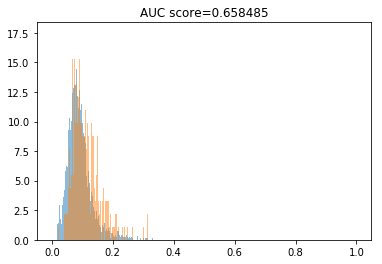

In [18]:
pipeline.fit(train, y_train)
prob_train = pipeline.predict_proba(train)[:,1]
prob_test = pipeline.predict_proba(test)[:,1]
bins = np.arange(0, 1, 0.001)
preds = pd.DataFrame(np.array([y_test.tolist(), prob_test])).T
a = plt.hist(prob_test[y_test == 0], bins=bins, alpha=0.5, normed=True)
a = plt.hist(prob_test[y_test == 1], bins=bins, alpha=0.5, normed=True)
plt.title('AUC score=%f' % roc_auc_score(y_test, prob_test))  ## możemy dać log_loss scora również
plt.show()

### Istotność cech

In [19]:
feature_importances = pipeline.named_steps['estimator'].feature_importances_
pd.DataFrame(feature_importances).sort_values(0, ascending=False)

0
0   0.116777
1   0.092050
5   0.079466
4   0.073785
9   0.072597
10  0.068756
17  0.049194
15  0.046473
24  0.046234
8   0.041518
25  0.040908
26  0.040403
21  0.040250
6   0.032714
23  0.029030
29  0.028889
11  0.024404
28  0.023857
16  0.012542
12  0.007625
18  0.006025
34  0.003956
33  0.003789
30  0.003665
32  0.003327
27  0.003297
7   0.002030
13  0.001848
14  0.001787
36  0.000601
35  0.000491
20  0.000463
19  0.000457
31  0.000403
22  0.000388
3   0.000000
2   0.000000

### Przykładowa wizualizacja istotności cech 

1. Pierwszy rząd (9 pól) zawiera istotność zmiennych numerycznych, kolejne pola wizualizują istotność kolejnych zmiennych z pipelinów dla zmiennych nominalnych. 
2. **To jest radosna twórczość, dlatego** nie jest do końca prawilna: ostatnie kwadraty są puste (imputowane średnią), by wymiary macierzy się zgadzały. Jeśli liczba zmiennych jest podzielna przez 9, wówczas nie ma potrzeby imputacji.

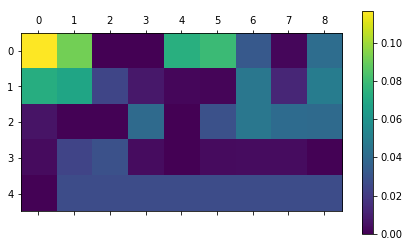

In [20]:
matrix_width = num.shape[1]
matrix_area = len(feature_importances)
fi = np.pad(feature_importances, (0, (matrix_width - matrix_area % matrix_width)), 'mean')
plt.matshow(fi.reshape(-1, 9))
plt.colorbar()

# 2. Inne transformacje - słowniki

In [17]:
cat.sample(3)

bin_country user_ip_country card_type  card_brand headers_accept headers_connection                                 headers_user_agent    headers_accept_encoding  \
12124          CL              CL    CREDIT        VISA            */*         keep-alive  "Mozilla/5.0 (Linux; Android 6.0; XT1063 Build...  "gzip, deflate, sdch, br"   
8294           ZA              ZA     DEBIT  MASTERCARD            */*         keep-alive  "Mozilla/5.0 (Windows NT 10.0; Win64; x64) App...  "gzip, deflate, sdch, br"   
3047           PR              PR    CREDIT  MASTERCARD            */*         keep-alive  "Mozilla/5.0 (iPhone; CPU iPhone OS 10_3_1 lik...            "gzip, deflate"   

             headers_accept_language         navigatorvendor navigatorappname navigatorproduct                                navigatorappversion navigatorappcodename  \
12124  "es-US,es-419;q=0.8,es;q=0.6"             Google Inc.         Netscape            Gecko  "5.0 (Linux; Android 6.0; XT1063 Build/MPB24.6...              Mozilla   
8294                "en-US,en;q=0.8"             Google Inc.         Netscape            Gecko  "5.0 (Windows NT 10.0; Win64; x64) AppleWebKit...              Mozilla   
3047                           es-xl  "Apple Computer, Inc."         Netscape            Gecko  "5.0 (iPhone; CPU iPhone OS 10_3_1 like Mac OS...              Mozilla   

                                                  plugin                                             screen language                                          useragent  \
12124  {"NavigatorPlugins": {}, "NavigatorMimeTypes":...  {"ColorDepth": 32, "visibility": {"hidden": fa...   es-419  "Mozilla/5.0 (Linux; Android 6.0; XT1063 Build...   
8294   {"NavigatorPlugins": {"0": {"name": "Widevine ...  {"ColorDepth": 24, "visibility": {"hidden": fa...    en-US  "Mozilla/5.0 (Windows NT 10.0; Win64; x64) App...   
3047   {"NavigatorPlugins": {}, "NavigatorMimeTypes":...  {"ColorDepth": 32, "visibility": {"hidden": fa...    es-XL  "Mozilla/5.0 (iPhone; CPU iPhone OS 10_3_1 lik...   

      donottrack navigatorplatform         navigatorlanguages navigatorjavaenabled navigatorcookieenabled flash_fonts flash_fields flash_devices  \
12124    unknown      Linux armv7l  ["es-US", "es-419", "es"]                False                   True         NaN          NaN           NaN   
8294     unknown             Win32            ["en-US", "en"]                False                   True         NaN          NaN           NaN   
3047     unknown            iPhone                  ["es-XL"]                False                   True         NaN          NaN           NaN   

                                              dwell_time                                        flight_time  
12124  {"avg": 14.036351351350202, "len": 37, "max": ...  {"avg": 416.7896296296315, "len": 27, "max": 9...  
8294   {"avg": 110.64914634146443, "len": 41, "max": ...  {"avg": 235.3173684210516, "len": 38, "max": 9...  
3047   {"avg": 15.446875000001228, "len": 32, "max": ...  {"avg": 279.47083333333285, "len": 24, "max": ...

### Zadanie 2.1 (UnpackDict)

In [21]:
class UnpackDict(TransformerMixin):
    def __init__(self):
        
        # Napisz klasę, która dla zadanej listy nazw kolum słownikowych (dla wygody z płaskim słownikiem -> 
        # czyli w praktyce zmiennych 'dwell_time', 'flight_time' :P) zwróci rozszerzoną ramkę 
        # danych zawierającą wartości z poszczególnych kluczy.
        
        pass

In [24]:
ud = UnpackDict(['dwell_time', 'flight_time'])
ud.fit_transform(cat).head()

dwell_time0  dwell_time1  dwell_time2  dwell_time3  dwell_time4  dwell_time5  flight_time0  flight_time1  flight_time2  flight_time3  flight_time4  flight_time5
0     6.362501        14.90        39.30        29.90         35.0    28.017143    185.524363        68.600       799.500        216.90          29.0    276.744828
1   -10.000000       -10.00       -10.00       -10.00        -10.0   -10.000000    -10.000000       -10.000       -10.000        -10.00         -10.0    -10.000000
2   112.984765        44.63       849.58        99.34         59.0   130.946949    311.411447      -357.505       998.955        104.77          47.0    172.349043
3   -10.000000       -10.00       -10.00       -10.00        -10.0   -10.000000    -10.000000       -10.000       -10.000        -10.00         -10.0    -10.000000
4    93.102553        79.94       542.46       139.98         34.0   161.719265    257.013028      -143.820       839.390        324.17          23.0    333.416957

### Zadanie 2.2 (DictVolume)
Dla tych, którzy odrobili zadanie 2.1 w domu :)

In [25]:
class DictVolume(TransformerMixin):
    def __init__(self):
        
        # Napisz klasę, która dla zadanej listy nazw kolum słownikowych zwróci
        # rozszerzoną ramkę  danych zawierającą liczbę liści danego słownika.
        
        pass

### Zadanie 2.1 (przykładowe rozwiązanie)

In [23]:
class UnpackDict(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None, **kwargs):
        assert all([ c in X.columns for c in self.columns])
        return self
    
    def transform(self, X, y=None, **kwargs):
        new_data_frames = []
        for colname in self.columns:
            col = X[colname]
            newcols = pd.DataFrame(col.fillna('{}').apply(lambda  val: eval(val).values()).tolist())
            newcols.columns = [ colname + str(v) for v in newcols.columns]
            new_data_frames.append(newcols)
        new_X = pd.concat(new_data_frames, axis=1)
        new_X.set_index(X.index, inplace=True)
        return new_X.fillna(-10)

# 3. Feature Selection

Dlaczego robić selekcję atrybutów?

1. Zmniejszając wymiar problemu eliminujemy szum i lepiej panujemy nad wariancją wyników.
2. Zmniejszamy ryzyko przeuczenia modelu.
3. Wiele modeli cierpi na "klątwa wymiarowości":
    - KNN: aby uchwycić frakcję r=1% losowych realizacji z rozkładu U(0,1) w jednostkowej 50-wymiarowej hiperkostce  oczekiwana długość krawędzi wynosi 0.91.
    - Regresja logistyczna/liniowa: brak jednoznacznego rozwiązania dla estymatora współczynników gdy p>n
4. Aby skrócić czas predykcji, nie nadużywać zasobów pamięciowych.

In [26]:
0.01 ** (1/50.0)

0.9120108393559098

## 3.1 Feature Importance Selector

1. Szybkie i łatwe.
2. Uczone na zbiorze treningowym (czym to skutkuje - np. w kontekście id=ków?)

In [27]:
class FeatureImportanceSelector(TransformerMixin):
    def __init__(self, num_features=30, estimator=RandomForestClassifier()):
        self.estimator = estimator
        self.good_columns = []
        self.sorted_features = []
        self.num_features = num_features
        
    def fit(self, X, y, **kwargs):
        self.estimator.fit(X, y)
        self.scores_ = self.estimator.feature_importances_
        self.good_columns = np.argsort(self.scores_)[-self.num_features:]
        if type(X) == type(pd.DataFrame()):
            self.features = X.columns
        return self
    
    def transform(self, X, y=None, **kwargs):
        if type(X) == type(pd.DataFrame()):
            return X.iloc[:, self.good_columns]
        else:
            return X[:, self.good_columns]

Zainteresowanym polecam:

`from sklearn.feature_selection import SelectFromModel`

oraz dokumentację:
http://scikit-learn.org/stable/modules/feature_selection.html

## 3.2 Shuffle Selector

1. Bardziej odporny na overfitting.
2. Estymowany na zbiorze walidacyjnym:
    - budujemy model,
    - każdą kolumę z osobna permutujemy -> tracimy informację, którą niosła ta kolumna,
    - dla każdej ze spermutowanych kolumn budujemy model na ramce z podmienioną kolumną,
    - obserwujemy wielkość uzyskanej straty dla każdego z modeli,
    - im większa strata na jakości modelu, gdy dana zmienna jest spermutowana, tym bardziej była ona istotna.

In [28]:
from sklearn.model_selection import train_test_split

class ShuffleSelector(TransformerMixin):
    def __init__(self, num_features=30, 
                 shuffle_counts_to_mean=5, 
                 estimator=RandomForestClassifier(), 
                 func_to_max=roc_auc_score): 
        self.estimator = estimator
        self.good_columns = []
        self.sorted_features = []
        self.num_features = num_features
        self.func_to_max = func_to_max
        self.shuffle_counts = shuffle_counts_to_mean
        
    def shuffle_procedure(self, X, y):
        p = X.shape[1]
        self.scores_ = np.zeros(p)
        for i in range(p):
            col = np.copy(X[:, i])
            scores = []
            for j in range(self.shuffle_counts):
                X[:, i] = np.random.permutation(col)
                shuffled_predictions = self.estimator.predict_proba(X)[:, 1]
                scores.append(self.func_to_max(y, shuffled_predictions))
            X[:, i] = col
            self.scores_[i] = np.mean(scores)
        return self
    
    def fit(self, X, y, **kwargs):
        xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, train_size=.75, shuffle=False)
        self.estimator.fit(xtrain, ytrain)
        self.shuffle_procedure(xvalid, yvalid)
        self.good_columns = np.argsort(self.scores_)[-self.num_features:]
        if type(X) == type(pd.DataFrame()):
            self.features = X.columns
        return self
    
    def transform(self, X, y=None, **kwargs):
        if type(X) == type(pd.DataFrame()):
            return X.iloc[:, self.good_columns]
        else:
            return X[:, self.good_columns]

## 3.3 One Column Model Selector
### Czyli radosna twórczość do której zachęcamy :)

1. Szybsza alternatywa dla shuffle selectora.
2. Do zastosowania, gdy nie spodziewamy się wielu/istotnych interakcji.

In [29]:
class TrainOnOneColumnSelector(TransformerMixin):    
    def __init__(self, num_features=30, estimator=RandomForestClassifier(), func_to_max=roc_auc_score):
        self.estimator = estimator
        self.good_columns = []
        self.num_features = num_features
        self.func_to_max = func_to_max
    
    def train_procedure(self, X, y):
        column_costs = {}
        p = X.shape[1]
        if type(X) == type(pd.DataFrame()):
            X = X.as_matrix()
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=.75, shuffle = False)
        self.scores_ = np.zeros(p)
        for i in range(p):
            col, col_val = X_train[:, i], X_valid[:, i]
            col, col_val = col.reshape(-1, 1), col_val.reshape(-1, 1)
            self.estimator.fit(col, y_train)
            predictions = self.estimator.predict_proba(col_val)[:, 1]
            score = self.func_to_max(y_valid, col_val)
            self.scores_[i] = score
        self.cost_df = pd.DataFrame(column_costs, index=['cost_value']).T
        return self.cost_df.sort_values('cost_value', ascending=False)  
    
    def fit(self, X, y, **kwargs):
        self.train_procedure(X, y)
        self.good_columns = np.argsort(self.scores_)[:self.num_features]
        if type(X) == type(pd.DataFrame()):
            self.features = X.columns
        print self.good_columns
        return self
    
    def transform(self, X, y=None, **kwargs):
        if type(X) == type(pd.DataFrame()):
            return X.iloc[:, self.good_columns]
        else:
            return X[:, self.good_columns]

## 3.4 Metody statystyczne 

1. Jeszcze szybsza alternatywa dla Shuffle Selectora, gdy mamy dużo kolumn i niezbyt dużo interakcji...
2. Oparte na testowaniu istotności każdej zmiennej niezależnie:
    - Select K Best selector
    - False Positive Rate (FPR) selector        
    - False Discovery Rate (FDR) selector


Zainteresowanym polecam:
    
`from sklearn.feature_selection import SelectKBest, SelectFpr, SelectFdr`

oraz odpowiednie dokumentacje do znalezienia na: http://scikit-learn.org/stable/modules/feature_selection.html

# 4. Budowanie pipelinów

Poniżej pomocnicze pipeliny zawierające niektóre z powyższych metod. Zachęcamy do pobawienia się nimi, dopisania własnych transformacji i "wykręcenia" jak najlepszych wyników.

In [31]:
categoric_pipeline = Pipeline([
    ('SelectCategoric', FunctionTransformer(lambda df: df.select_dtypes(exclude=[np.number]), validate=False)),
    ('FillNA', FunctionTransformer(lambda df: df.fillna(''), validate=False)),
    ('ToString', FunctionTransformer(lambda df: df.applymap(lambda x: str(x)), validate=False)),
#     ('Encode', HashingTrick(max_cols=1000)),
    ('Encode', SimpleHash()),
#     ('Encode', DFCounterTransformer()),
])

feature_union = FeatureUnion([
    ## TU JEST miejsce na własne transformacje i pipeliny, np:
    ('numeric', numeric_pipeline),
    ('klawisze', UnpackDict(columns=['dwell_time','flight_time'])),
    ('categoric', categoric_pipeline)
])

K = 30
pipeline = Pipeline([
    ('transformed', feature_union),
#     ('selection', FeatureImportanceSelector(num_features=K, estimator=RandomForestClassifier(n_estimators=100, min_samples_leaf=50))),
#     ('selection', ShuffleSelector(num_features=K, shuffle_counts_to_mean=3)),
    ('selection', TrainOnOneColumnSelector(
        num_features = K,
        estimator = RandomForestClassifier(n_estimators=100, min_samples_leaf=200, n_jobs=3),
#         estimator = BernoulliNB(),
#         func_to_max = lambda b,b_est: -log_loss(b,b_est)
    )),
    ('estimator', RandomForestClassifier(n_estimators=100, min_samples_leaf=37, n_jobs=4)),
])

In [32]:
pipeline.fit(train, y_train)
prob_train = pipeline.predict_proba(train)[:,1]
prob_test = pipeline.predict_proba(test)[:,1]
preds = pd.DataFrame(np.array([y_test.tolist(), prob_test])).T

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].hist(prob_test[y_test == 0], bins=bins, alpha=0.5, normed=True)
ax[0].hist(prob_test[y_test == 1], bins=bins, alpha=0.5, normed=True)
ax[0].set_title('AUC score = %f' % roc_auc_score(y_test, prob_test))

fs_scores = pipeline.named_steps['selection'].scores_
l = len(fs_scores)
fs_scores = np.pad(fs_scores, (0, (9 - l % 9)), 'mean')
x = ax[1].matshow(fs_scores.reshape(-1, 9))
plt.colorbar(x)

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


[23  0 28  1 26 21 27 22 46 45 44 40 18 38 16  3  2 37 20 48 15 29 39  7
 34 43 31 32 17 47]


### Ćwiczenia

* Przejrzenie danych,
* wymyślenie
* i napisanie

transformacji, które polepszą model.

Stworzone transformacje posłużą nam w kolejnych zajęciach do uczenia jak najlepszego modelu.

### Dodatek
#### Feature Union, który zachowuje pandasowe ramki danych

In [98]:
from sklearn.externals.joblib import Parallel, delayed
from sklearn.pipeline import _fit_transform_one, _transform_one

class DaftFeatureUnion(FeatureUnion):
    def fit_transform(self, X, y=None, **fit_params):
        result = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_transform_one)(trans, weight, X, y, **fit_params)
            for name, trans, weight in self._iter())

        Xs, transformers = zip(*result)
        self._update_transformer_list(transformers)
        return pd.concat(Xs, axis=1)

    def transform(self, X, **kwargs):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(trans, weight, X, **kwargs)
            for name, trans, weight in self._iter())
        return pd.concat(Xs, axis=1)

In [119]:
feature_union = DaftFeatureUnion([
    ('numeric', numeric_pipeline),
    ('klawisze', UnpackDict(columns=['dwell_time','flight_time'])),
    ('categoric', categoric_pipeline)
])

K = 30
pipeline = Pipeline([
    ('transformed', feature_union),
    ('selection', FeatureImportanceSelector(num_features=K, estimator=RandomForestClassifier(n_estimators=100, min_samples_leaf=50))),
    ('estimator', RandomForestClassifier(n_estimators=100, min_samples_leaf=37, n_jobs=4)),
])

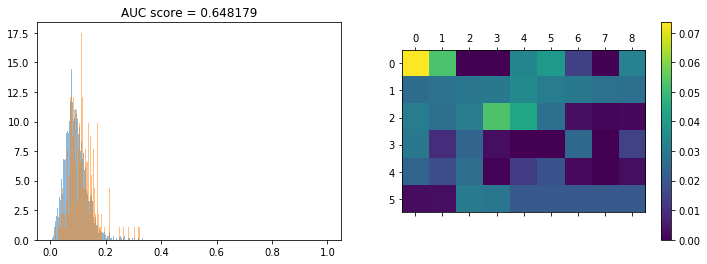

In [120]:
pipeline.fit(train, y_train)
prob_train = pipeline.predict_proba(train)[:,1]
prob_test = pipeline.predict_proba(test)[:,1]
preds = pd.DataFrame(np.array([y_test.tolist(), prob_test])).T

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].hist(prob_test[y_test == 0], bins=bins, alpha=0.5, normed=True)
ax[0].hist(prob_test[y_test == 1], bins=bins, alpha=0.5, normed=True)
ax[0].set_title('AUC score = %f' % roc_auc_score(y_test, prob_test))

selection = pipeline.named_steps['selection']
fs_scores = selection.scores_
l = len(fs_scores)
fs_scores = np.pad(fs_scores, (0, (9 - l % 9)), 'mean')
x = ax[1].matshow(fs_scores.reshape(-1, 9))
plt.colorbar(x)

In [121]:
pd.DataFrame([selection.features, selection.scores_]).T.sort_values(1, ascending=False)

0            1
0                       bin    0.0734939
21              bin_country    0.0530944
1                 issuer_id    0.0525708
22          user_ip_country    0.0441694
5     timeofrequestresponse    0.0396316
13              dwell_time4    0.0346141
4       timeoftotalpageload     0.033406
8            timezoneoffset    0.0326283
18             flight_time3    0.0312569
14              dwell_time5    0.0309877
20             flight_time5    0.0308839
47               dwell_time    0.0305204
15             flight_time0    0.0297497
12              dwell_time3    0.0297107
27       headers_user_agent    0.0295585
11              dwell_time2    0.0288644
48              flight_time    0.0287387
16             flight_time1    0.0275107
10              dwell_time1    0.0274054
23                card_type    0.0269154
17             flight_time2    0.0267102
19             flight_time4     0.026536
38                useragent    0.0263978
9               dwell_time0    0.0258808
33      navigatorappversion    0.0247085
29  headers_accept_language    0.0238742
36                   screen     0.023814
41       navigatorlanguages    0.0184389
37                 language    0.0177513
35                   plugin    0.0141625
6             windowhistory    0.0139915
40        navigatorplatform    0.0126976
28  headers_accept_encoding   0.00974013
24               card_brand   0.00312907
46            flash_devices   0.00273542
30          navigatorvendor   0.00264745
44              flash_fonts    0.0026335
45             flash_fields   0.00256367
42     navigatorjavaenabled   0.00172349
26       headers_connection   0.00167936
25           headers_accept    0.0011968
39               donottrack  0.000720022
7       navigatorproductsub  0.000374472
43   navigatorcookieenabled   7.7589e-05
31         navigatorappname  5.60453e-05
34     navigatorappcodename  4.13202e-05
32         navigatorproduct  7.29976e-06
3    headers_content_length            0
2      headers_content_type            0